In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import importlib
import galaxy

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [3]:
def load_log(fname):
    log = np.genfromtxt(fname)
    _, indices = np.unique(log[:,0], return_index=True)
    log = log[sorted(indices)]
    return log

In [12]:
sfr = {}
sfr['MW7_GSE4_l5'] = load_log(basepath + 'runs/MW7_GSE4/lvl5-denscut-SMUGGLE/output/sfr.txt')
sfr['MW7_GSE4_gfm_l5'] = load_log(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64/output/sfr.txt')

In [14]:
def bin_sfr(sfr_log, dt=0.05):
    time = sfr_log[:,0]
    sfr = sfr_log[:,2]
    tmin = 0.0
    
    time_binned = []
    sfr_binned = []
    
    while tmin < time[-1]:
        key = np.logical_and(time >= tmin, time < tmin + dt)
        time_binned.append(np.mean(time[key]))
        sfr_binned.append(np.mean(sfr[key]))
        tmin += dt
    
    return np.array(time_binned), np.array(sfr_binned)
    

(0.0, 66.79277171901508)

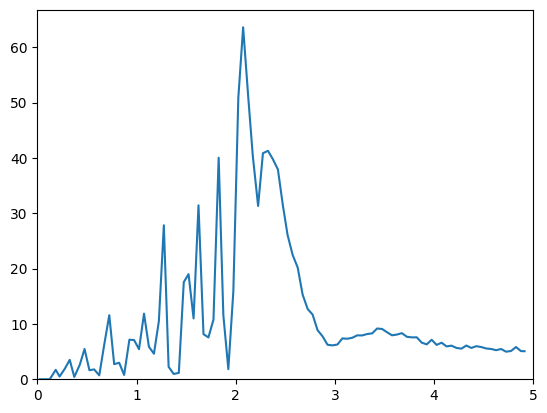

In [16]:
time_binned, sfr_binned = bin_sfr(sfr['MW7_GSE4_l5'])
plt.plot(time_binned, sfr_binned)
plt.xlim(0, 5)
plt.ylim(0, None)

In [18]:
def get_logFeH_logMgFe(gal, ptype=4):
    GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
    
    part = getattr(gal.sn, 'part'+str(ptype))
    
    FeH = part.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    MgH = part.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    MgFe = MgH/FeH
    logMgH = np.log10(MgH)
    logMgFe = np.log10(MgFe)
    
    return logFeH, logMgH, logMgFe

In [67]:
def in_SN(gal, ptype, Rmin=4, Rmax=16, zmin=0, zmax=3):
    part = getattr(gal.sn, 'part'+str(ptype))
    R = np.linalg.norm(part.rotpos[:,:2], axis=1)
    z = part.rotpos[:,2]
    key_R = np.logical_and(R < Rmax, R > Rmin)
    key = np.logical_and(key_R, np.abs(z) < zmax)
    key = np.logical_and(key, np.abs(z) > zmin)
    
    return key
    
def plot_map(fig, ax, gal, scalar=None, subsamp=None, tform_min=0, tform_max=10,
             Rmin=4, Rmax=16, zmin=0, zmax=3, exclude=None):
    
    # vmin = None
    # vmax = 0.008
    # vmax = None
    
    logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
    
    key = in_SN(gal, 4, Rmin=Rmin, Rmax=Rmax, zmin=zmin, zmax=zmax)
    
    tform = gal.sn.part4.GFM_StellarFormationTime
    key = np.logical_and(key, tform > tform_min)
    key = np.logical_and(key, tform < tform_max)
    
    if exclude is not None:
        key_low = np.logical_and(key, tform < exclude[0])
        key_high = np.logical_and(key, tform > exclude[1])
        key = np.logical_or(key_low, key_high)
    
    mass = np.copy(gal.sn.part4.mass.value)
    
    if scalar is not None:
        mass *= gal.sn.part4.PassiveScalars[:,scalar]
    
    print(np.sum(mass[key]))
    
    if subsamp is not None and np.sum(key) > subsamp:
        key_w = np.where(key)[0]
        key_w = np.random.choice(key_w, subsamp, replace=False)
        key = np.full(len(key), False)
        key[key_w] = True
        print('subsampled to:', np.sum(key))

    # logFeH_bins  = np.linspace(-1, 0.75, 75)
    # logMgFe_bins = np.linspace(0.15, 0.4, 75)
    
    logFeH_bins  = np.linspace(-1.5, 0.6, 50)
    logMgFe_bins = np.linspace(-0.05, 0.65, 50) -0.6

    mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], logMgFe[key], mass[key], 
                                                     statistic='sum', bins=[logFeH_bins, logMgFe_bins])

    print(np.median(logFeH[key]), np.median(logMgFe[key]))
    
    # downstairs = np.max(mbin, axis=1)
    # vmin = 0.01
    # vmax = 0.15
    
    downstairs = np.sum(mbin, axis=1)
    vmin = 0.0001
    vmax = 0.01
    
    # downstairs[downstairs == 0.0] = 1e-20
    # mbin = (mbin.T / downstairs).T
    # mbin[mbin < vmin] = vmin
    
    extent = [x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]]
    
    # vmin=1e-5
    # vmax=0.0001
    # vmin=None
    # vmax=None
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # norm = mpl.colors.PowerNorm(gamma=0.3)
    im = ax.imshow(mbin.T, origin='lower',
               extent=extent, norm=norm)

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('auto')
    
    return im

In [68]:
gal = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-SMUGGLE/output', 180, orient=True)

0.08724512
-0.059909545 -0.41216165


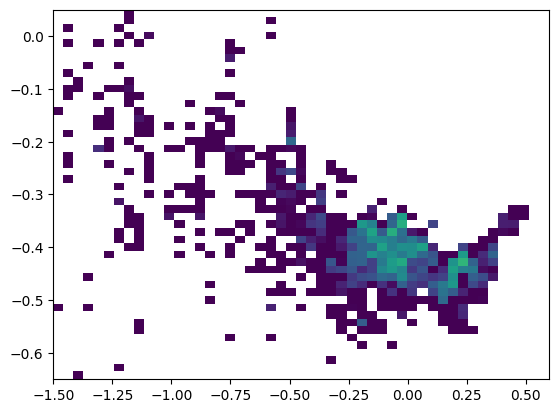

In [69]:
fig, ax = plt.subplots(1, 1)

plot_map(fig, ax, gal)